# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in **(0,0)**, and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [4]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [31]:
def compute_distance(x, y):
    # TODO: Compute the Euclidean distance from the origin
    distance = np.sqrt( x**2 + y**2 )
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)
# p: polinomial coefficients, highest degree first

def predict(distance, poly_coeffs):
    # TODO:  Predict the SNR from a given model
    distance_powers = np.ones(shape = (1, len(distance)))
    for k in range(len(poly_coeffs) - 1):
        distance_powers = np.vstack((distance_powers, distance**(k+1)))
    predicted_SNR = np.dot(poly_coeffs[::-1], distance_powers) 
    return predicted_SNR

def evaluate(distance, SNR, poly_coeffs):
    # TODO: Compute the error of the polynomial fit on the chosen data
    predicted_SNR = predict(distance, poly_coeffs)
    mse = np.mean((predicted_SNR - SNR)**2)
    return mse



def separate_test(distance, SNR, test_points):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly
    tot_size = len(SNR)
    idxs = np.arange(tot_size)
    if (test_points <= tot_size):
        test_idxs = np.random.choice(a = idxs, size = test_points)
        train_idxs = np.setdiff1d(idxs, test_idxs)
        x_train = distance[train_idxs,]
        x_test = distance[test_idxs]
        y_train = SNR[train_idxs]
        y_test = SNR[test_idxs]
    else:
        raise ValueError("test_points must be <= dataset size.")
    return x_train, y_train, x_test, y_test

Total points: 200


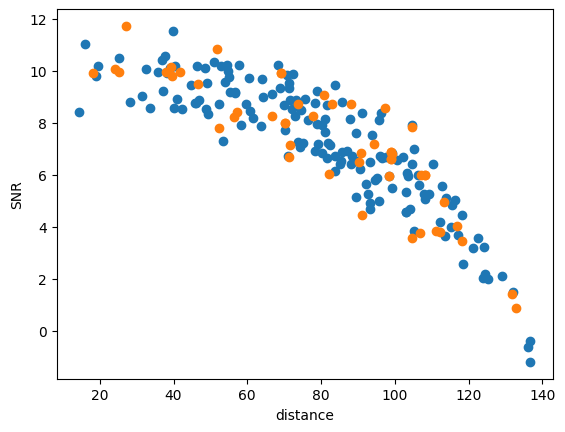

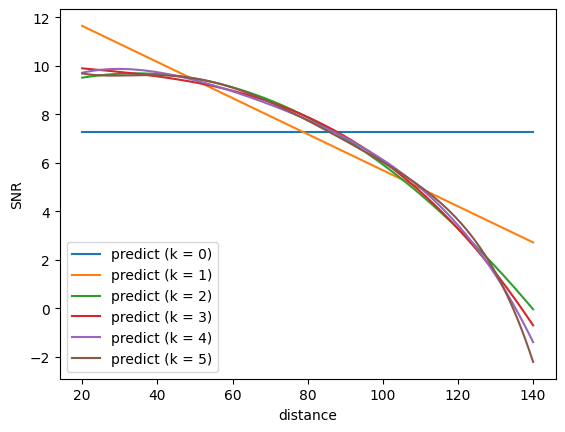

In [49]:
# TODO: separate the training and test sets and create a scatter plot of the SNR as a function of the distance

print(f"Total points: {len(SNR)}")
distance = compute_distance(x, y)

x_train, y_train, x_test, y_test = separate_test(distance, SNR, 50)

plt.scatter(x_train, y_train, label = "train")
plt.scatter(x_test, y_test, label = "test")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.show()


# MY ADDITION: just to verify functions work
for k in range(6):
    x_sample = np.linspace(20, 140, num = 1000)
    p = fit(x_train, y_train, k)
    y_sample_predict = predict(x_sample, p)
    plt.plot(x_sample, y_sample_predict, label = f"predict (k = {k})")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.legend()
plt.show()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [ ]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    



    return best, results

In [ ]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree

In [ ]:
# TODO: get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [ ]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    return best, results

In [ ]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree


## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [ ]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process

    return best, results

In [ ]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree

### TEST

Check the performance of the three solutions on the test set: which one does best?


In [ ]:
# TODO: plot the results